#  **Reading the Observation File from Observations A, B, and C**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pyvinecopulib as pv
import seaborn as sns
from scipy import stats
from py_banshee.copula_test import cvm_statistic
from scipy.interpolate import interp1d
from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.d_cal import test_distance
from py_banshee.copula_test import cvm_statistic
from py_banshee.prediction import inference,conditional_margins_hist

%matplotlib inline 

In [11]:
" Data at Point A"
# Read the data, skipping the header comments and setting the correct column names
# Load the CSV file into a DataFrame
dataA = pd.read_csv("Clean\\ObservationPointA.csv", sep=",", comment="#", header=0)
dataA.columns = ["Datetime", "Predicted Water Level Point A", 
                "Observed Water Level Point A"]

" Data at Point B"
# Read the data, skipping the header comments and setting the correct column names
dataB = pd.read_csv("Raw\\DataB.txt", sep="\t", comment="#", header=1)

# Rename columns for clarity
dataB.columns = ["Agency_cd", "site_no", "Datetime", "Timezone", 
           "Gage_Seaward_Ft", "Approval Code", 
           "Gage_Landward_Ft", "Approval Code"]


# Convert 'Datetime' column to datetime format
dataB["Datetime"] = pd.to_datetime(dataB["Datetime"])

"Data at Point C"
# Read the tab-delimited data into a Pandas DataFrame, skipping header lines
dataC = pd.read_csv("Raw\\DataC.txt", sep="\t", comment="#", header=1)

# Rename columns for easier understanding (based on the file description)
dataC.columns =  ["Agency_cd", "site_no", "Datetime", "Timezone", 
           "Gage_height_ft", "data_code"]

# Convert datetime column to proper datetime format
dataC["Datetime"] = pd.to_datetime(dataC["Datetime"])


" Data at Point D "
# Read the data, skipping the header comments and setting the correct column names
dataD = pd.read_csv("Raw\\DataD.txt", sep="\t", comment="#", header=1)

# Rename columns for clarity
dataD.columns = ["Agency Code", "Site Number", "Datetime", "Time Zone", 
                "Gage Height (ft) Point D", "Approval Code"]

# Convert 'Datetime' column to datetime format
dataD["Datetime"] = pd.to_datetime(dataD["Datetime"])


## **Change the Data Into Meter** ##

In [12]:
dataB['Gage Height Landward (m) Point B']= dataB['Gage_Landward_Ft'] * 0.308
dataC['Gage Height (m) Point C']= dataC['Gage_height_ft'] * 0.308
dataD['Gage Height (m) Point D']= dataD['Gage Height (ft) Point D'] * 0.308


dataB['Gage Height Landward (m) Point B'] =dataB['Gage Height Landward (m) Point B'] - 0.2 #Altimetry Datum on Point B is NGVD 29
dataD['Gage Height (m) Point D'] =dataD['Gage Height (m) Point D'] - 0.2 #Altimetry Datum on Point B is NGVD 29

In [13]:
# Ensure 'Datetime' columns are properly formatted
dataA['Datetime'] = pd.to_datetime(dataA['Datetime'])
dataB['Datetime'] = pd.to_datetime(dataB['Datetime'])
dataC['Datetime'] = pd.to_datetime(dataC['Datetime'])
dataD['Datetime'] = pd.to_datetime(dataD['Datetime'])

# Shift dataA by -3 hours (left shift)
dataA['Datetime'] = dataA['Datetime'] - pd.Timedelta(hours=3)

# Shift dataB by +2 hours (right shift)
dataB['Datetime'] = dataB['Datetime'] + pd.Timedelta(hours=2)

# Get the start and end range of dataB, dataC, and dataD
start = max(dataB['Datetime'].min(), dataC['Datetime'].min(), dataD['Datetime'].min())
end = min(dataB['Datetime'].max(), dataC['Datetime'].max(), dataD['Datetime'].max())

# Slice dataA to only include rows within the range of dataB, dataC, and dataD
dataA_sliced = dataA[(dataA['Datetime'] >= start) & (dataA['Datetime'] <= end)]

# Slice dataB, dataC, and dataD to match dataA_sliced timestamps
dataB_sliced = dataB[dataB['Datetime'].isin(dataA_sliced['Datetime'])]
dataC_sliced = dataC[dataC['Datetime'].isin(dataA_sliced['Datetime'])]
dataD_sliced = dataD[dataD['Datetime'].isin(dataA_sliced['Datetime'])]

# Merge datasets
data_merged_AB = pd.merge(dataA_sliced, dataB_sliced, on="Datetime", how="inner", suffixes=("_Loc1", "_Loc2"))
data_merged_ABC = pd.merge(data_merged_AB, dataC_sliced, on="Datetime", how="inner")
data_merged_A_B_C_D = pd.merge(data_merged_ABC, dataD_sliced, on="Datetime", how="inner")

In [14]:
data_merged_A_B_C_D = data_merged_A_B_C_D.dropna()
selected_columns_A_B = ['Datetime',
    'Observed Water Level Point A',
    'Gage Height Landward (m) Point B',
    'Gage Height (m) Point C',
    'Gage Height (m) Point D'
]

data_cleaned_forABCD = data_merged_A_B_C_D[selected_columns_A_B]

In [15]:
# Rename the columns
data_cleaned_forABCD.rename(columns={
    'Observed Water Level Point A': 'WL A',
    'Gage Height Landward (m) Point B': 'WL B',
    'Gage Height (m) Point C': 'WL C',
    'Gage Height (m) Point D': 'WL D'
}, inplace=True)

# Export the updated DataFrame to a CSV file
filepath = r"./Clean/Obs_WL_All_Points.csv"
data_cleaned_forABCD.to_csv(filepath, index=False)

C:\Users\ferna\AppData\Local\Temp\ipykernel_32308\335495815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned_forABCD.rename(columns={


In [16]:
specific_datetime = '2022-12-31 00:00:00'
dataA_at_specific_datetime = dataB[dataB['Datetime'] == specific_datetime]

# Display the result
print(dataA_at_specific_datetime)

       Agency_cd  site_no   Datetime Timezone  Gage_Seaward_Ft Approval Code  \
109034      USGS  8079120 2022-12-31      CST             1.85             A   

        Gage_Landward_Ft Approval Code  Gage Height Landward (m) Point B  
109034              1.85             A                            0.3698  


In [17]:
data_cleaned_forABCD

,Datetime,WL A,WL B,WL C,WL D
0,2020-01-01 02:00:00,0.278,0.23120,0.37884,1.58948
1,2020-01-01 03:00:00,0.242,0.11108,0.28644,1.58948
2,2020-01-01 04:00:00,0.178,0.21272,0.27720,1.58948
3,2020-01-01 05:00:00,0.189,0.16036,0.26488,1.58640
4,2020-01-01 06:00:00,0.179,0.15728,0.22484,1.58640
...,...,...,...,...,...
34735,2023-12-31 16:00:00,-0.222,-0.16304,0.16324,2.81224
34736,2023-12-31 17:00:00,-0.173,-0.07988,0.22484,2.79376
34737,2023-12-31 18:00:00,-0.076,0.02484,0.29876,2.77528
34738,2023-12-31 19:00:00,0.037,0.12648,0.40964,2.76296


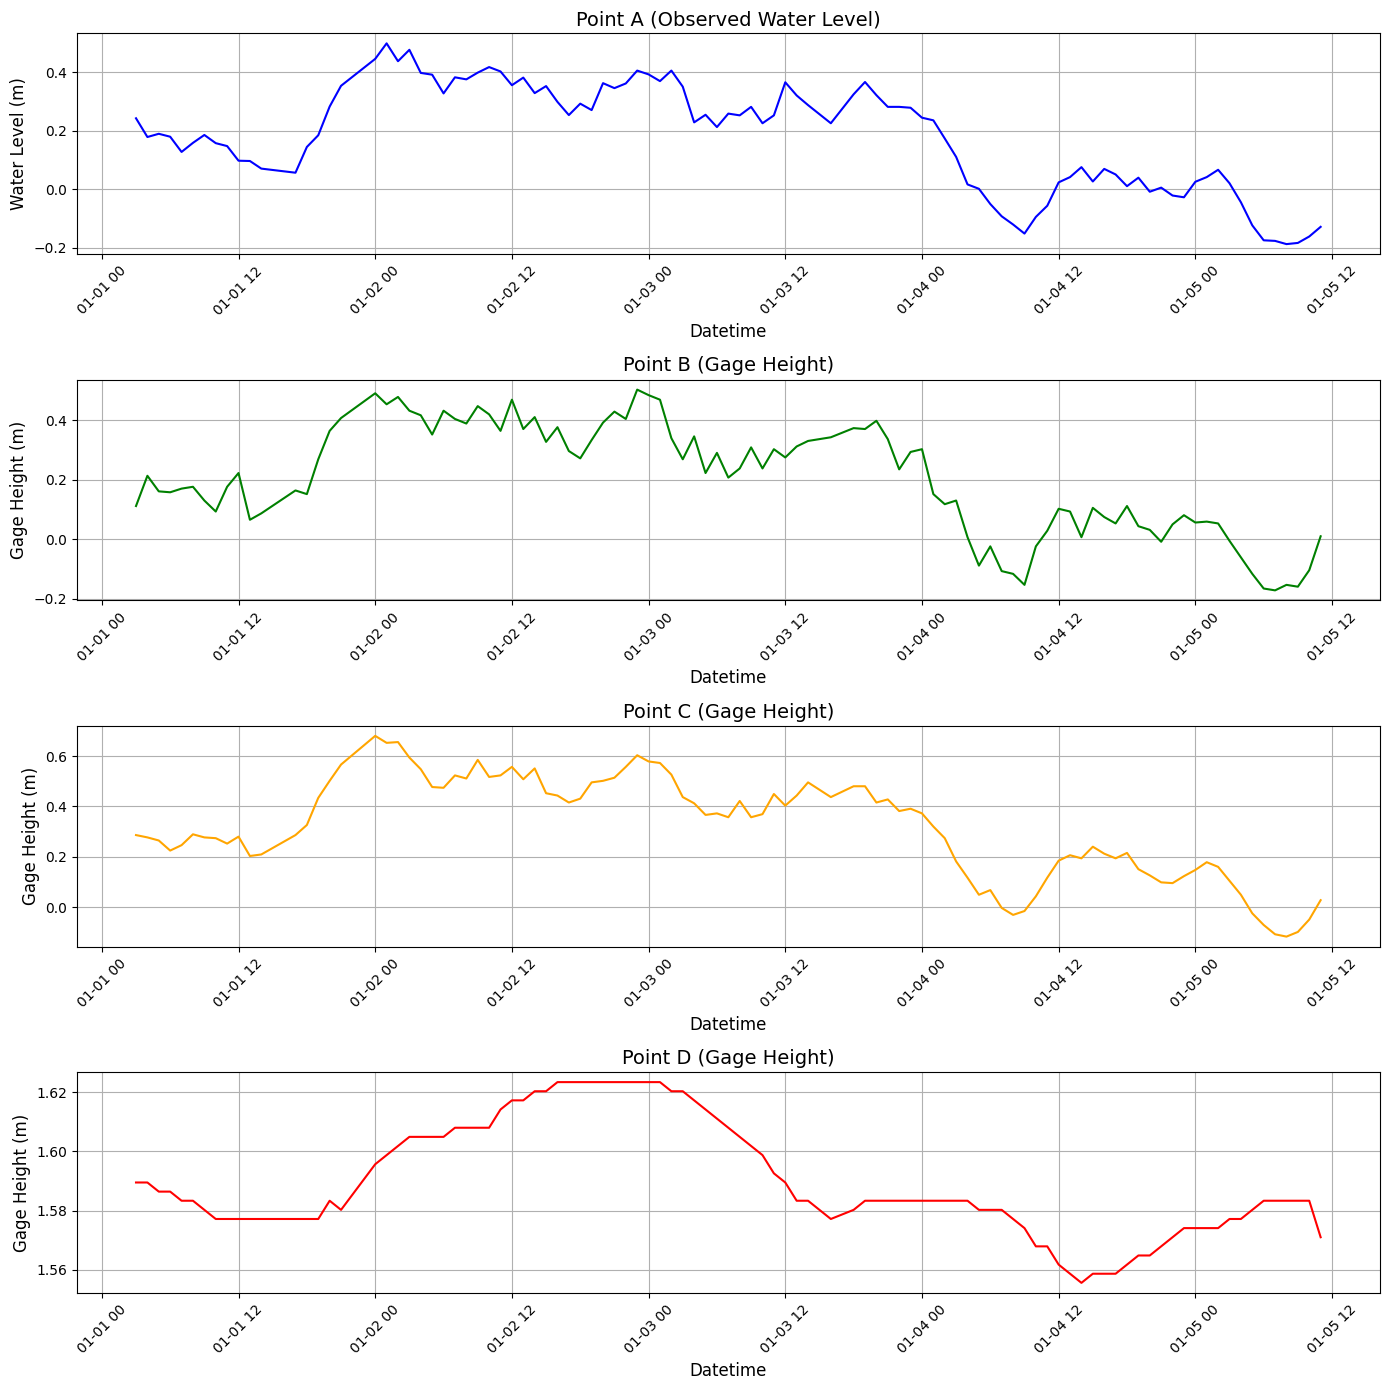

In [18]:
# Create subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 14))

# Plot each point in a separate subplot
axes[0].plot(data_cleaned_forABCD['Datetime'][1:100], data_cleaned_forABCD['WL A'][1:100], color='blue')
axes[0].set_title('Point A (Observed Water Level)', fontsize=14)
axes[0].set_ylabel('Water Level (m)', fontsize=12)
axes[0].set_xlabel('Datetime', fontsize=12)  # Add x-axis label for subplot
axes[0].grid(True)
axes[0].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better readability

axes[1].plot(data_cleaned_forABCD['Datetime'][1:100], data_cleaned_forABCD['WL B'][1:100], color='green')
axes[1].set_title('Point B (Gage Height)', fontsize=14)
axes[1].set_ylabel('Gage Height (m)', fontsize=12)
axes[1].set_xlabel('Datetime', fontsize=12)  # Add x-axis label for subplot
axes[1].grid(True)
axes[1].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better readability

axes[2].plot(data_cleaned_forABCD['Datetime'][1:100], data_cleaned_forABCD['WL C'][1:100], color='orange')
axes[2].set_title('Point C (Gage Height)', fontsize=14)
axes[2].set_ylabel('Gage Height (m)', fontsize=12)
axes[2].set_xlabel('Datetime', fontsize=12)  # Add x-axis label for subplot
axes[2].grid(True)
axes[2].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better readability

axes[3].plot(data_cleaned_forABCD['Datetime'][1:100], data_cleaned_forABCD['WL D'][1:100], color='red')
axes[3].set_title('Point D (Gage Height)', fontsize=14)
axes[3].set_ylabel('Gage Height (m)', fontsize=12)
axes[3].set_xlabel('Datetime', fontsize=12)  # Add x-axis label for subplot
axes[3].grid(True)
axes[3].tick_params(axis='x', rotation=45)  # Rotate x-tick labels for better readability

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
fig.savefig("Timeseries Observations.jpg")
